#Group 11 project 1
  Group members:
  - Jennifer Becerra
  - Sierra Landacre
  - Don Krapohl


  Our proposal is at https://docs.google.com/document/d/13be3PvzDU99-EkooqcpcbDVWiMm37aB0SOlEGFb2J7U/edit?tab=t.0

  Summary:  This data analysis group project will use basic deep learning techniques and algorithms to predict the probability of the five most widespread COVID-19 variants in each country based on societal and infrastructure information.

  Citations
  - Franceschini, L. (2024, April). The World Factbook by CIA, Version 4. Retrieved 01/29/2025 from https://www.kaggle.com/datasets/lucafrance/the-world-factbook-by-cia

  - Giordano, D, SARS-CoV-2-Variants, (2022), GitHub repository, https://github.com/3dgiordano/SARS-CoV-2-Variants.


**Mount Google Drive**

In [11]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Libraries**

In [12]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import os
import glob
import re
import seaborn as sns
from datetime import timedelta
#from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # for doing time series smoothing on variants
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report

**Define Paths**

In [13]:
# Set Up File Paths
standard_colab_google_mount = "/content/drive"
base_path = "/content/drive/MyDrive/project1_data/"
country_data_path = f"{base_path}country_data/"
country_data_file_path = f"{country_data_path}countries.csv"
covid_data_path = f"{base_path}SARS-CoV-2-Variants/"


**Define Preprocessing Models**

We will reuse the encoders later after fitting to process our test data.

In [14]:
variant_encoder = LabelEncoder()
country_encoder = LabelEncoder()
country_metric_scaler = StandardScaler()
covid_date_scaler = MinMaxScaler()
ohe_variant = OneHotEncoder()

**Load Country Data**  

There are two sets of data, the country data with political and other national information, and the COVID data with counts per day of COVID variants in a country. This is the country portion

In [15]:
# Load country data
country_df = pd.read_csv(country_data_file_path)

# Keep only specific columns
country_cols_to_keep = [
    'Country',
    'Environment: Urbanization - urban population',
    'People and Society: Hospital bed density',
    'People and Society: Obesity - adult prevalence rate'
]
country_df = country_df[country_cols_to_keep]

print("Country data loaded and filtered successfully.")
print(country_df.head())




Country data loaded and filtered successfully.
         Country Environment: Urbanization - urban population  \
0  United States             83.3% of total population (2023)   
1    Afghanistan             26.9% of total population (2023)   
2       Akrotiri                                          NaN   
3        Albania             64.6% of total population (2023)   
4        Algeria             75.3% of total population (2023)   

  People and Society: Hospital bed density  \
0         2.9 beds/1,000 population (2017)   
1         0.4 beds/1,000 population (2017)   
2                                      NaN   
3         2.9 beds/1,000 population (2013)   
4         1.9 beds/1,000 population (2015)   

  People and Society: Obesity - adult prevalence rate  
0                                       36.2% (2016)   
1                                        5.5% (2016)   
2                                                NaN   
3                                       21.7% (2016)   
4    

**Combine COVID Data Files Using Glob**

In [16]:
# Our files don't have complete coverage of all variants. We'll use the USA.csv
#   file to establish our structure since it has all of them.
file_path = os.path.join(covid_data_path, 'USA.csv')  # set to use the USA data
try:
  combined_df = pd.read_csv(file_path, nrows=0)
except Exception as e:
  print(f"An error occurred: {e}")
  raise KeyboardInterrupt   # we have an error here so stop.


In [17]:
# Use glob to find all CSV files in the directory
csv_files = glob.glob(os.path.join(covid_data_path, '*.csv'))

# Loop through the list of CSV files and concatenate them
for file in csv_files:
  try:
    df = pd.read_csv(file)
    # Ensure column names match combined_df
    df = df.reindex(columns=combined_df.columns)  # Align columns

    # ------------------ prep for finding the largest covid variant in the row -----------
    # We have to make the covid variant data numeric, fill Na, etc.
    numeric_cols = df.columns.difference(['location', 'date'])     # consider everything else numeric
    df.fillna(0, inplace=True)                                     # fill in zeroes
    df.replace('NaN', "0", inplace=True)                           # fix NaNs for now

    # Numbers are in #,# format. We'd like floating-point #.# format so fix them
    for col in df.columns:
        if col in numeric_cols:
            try:
                # If we can replace a comma, do it and retype the dtype
                df[col] = df[col].str.replace(',', '.').astype(float)
            except:
                continue  # Ignore errors

    # Fill missing values with 0.0
    df = df.fillna(0.0)

  except pd.errors.EmptyDataError:
      print(f"Empty data error for file: {file}")
  except Exception as e:
      print(f"An error occurred for file: {file}, {e}")
      print(e)

  # Avoiding fragmentation by using pd.concat"
  combined_df = pd.concat([combined_df, df], ignore_index=True)

# we've loaded some files that have invalid formats.  Remove those rows.
# Convert to datetime, setting errors='coerce' to turn bad values into NaT
combined_df['date'] = pd.to_datetime(combined_df['date'], errors='coerce')

# Drop rows where 'date' is NaT (invalid dates)
combined_df = combined_df.dropna(subset=['date'])


print("COVID data loaded and combined successfully.")
print(combined_df.head(2))
print(f"Total number of rows: {combined_df.shape[0]}")
print(f"Total number of columns: {combined_df.shape[1]}")

local_combined_df = combined_df.copy()    # make a local copy so we can mess up without reloading

<ipython-input-17-7371ccd13f19>:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([combined_df, df], ignore_index=True)


Empty data error for file: /content/drive/MyDrive/project1_data/SARS-CoV-2-Variants/Macao.csv
COVID data loaded and combined successfully.
  location       date  A (Lineage)  A.23.1  A.27  A.28  AD (Lineage)  \
0  Austria 2020-03-08     0.000000     0.0   0.0   0.0           0.0   
1  Austria 2020-03-22     1.568627     0.0   0.0   0.0           0.0   

   AE (Lineage)  AK (Lineage)  AL (Lineage)  AM (Lineage)  AP (Lineage)  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   

   AU (Lineage)  AW (Lineage)  AZ (Lineage)  Alpha (WHO VOC)  \
0           0.0           0.0           0.0              0.0   
1           0.0           0.0           0.0              0.0   

   Alpha - Q.1 (WHO VOC)  Alpha - Q.2 (WHO VOC)  Alpha - Q.3 (WHO VOC)  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   

  

## Preprocessing

**Preprocessing Methods**

In [18]:
# Our data is composed of varying degrees of reporting frequency so the data are sparse.
# To approach this problem as time series since we have reporting dates we'll:
# 1. Generate a date row for for every country with variant information
# 2.
def fill_missing_dates(df):
    # Convert date column to datetime if it's not already. This is for sorting and date ops
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])

    # Get all unique countries
    all_countries = df['Country'].unique()

    # Create a complete date range (all calendar dates)
    min_date = df['date'].min()
    max_date = df['date'].max()
    # Generate a keyset of all dates between our first and last dates
    all_dates = pd.date_range(start=min_date, end=max_date)

    full_index = pd.MultiIndex.from_product([all_countries, all_dates], names=["Country", "date"])
    full_df = pd.DataFrame(index=full_index).reset_index()

    # Merge with the original dataset
    merged_df = full_df.merge(df, on=["Country", "date"], how="left")

    # Forward-fill missing values within each country
    merged_df.sort_values(["Country", "date"], inplace=True)
    merged_df[['Other', 'Nu', 'Lambda', 'Eta', 'Chi', 'Alpha',
       'Zeta', 'Mu', 'Iota', 'Pi', 'Kappa', 'Rho', 'Gamma', 'Epsilon',
       'Upsilon', 'Theta', 'Sigma', 'Delta', 'Beta']] = merged_df.groupby("Country")[['Other', 'Nu', 'Lambda', 'Eta', 'Chi', 'Alpha',
       'Zeta', 'Mu', 'Iota', 'Pi', 'Kappa', 'Rho', 'Gamma', 'Epsilon',
       'Upsilon', 'Theta', 'Sigma', 'Delta', 'Beta']].ffill()

    # Now, we did a forward fill.  If there was no data for the first date we filled with NaN. Fix it
    merged_df.fillna(0.0, inplace=True)
    return merged_df

# -----------------------------------------------------------------------------------------------
# This method is designed to take the large number of minor variants and reduce them
#   to a columns mapped to greek letter variants. Example, in the source data
#   A.23.1 is an Alpha variant and will be aggregated within the Alpha variants.
# Use regex and/or map the columns to Greek base variants for dimensionality reduction
def aggregate_variant_columns(df):
    # Create a map of letter variants to Greek letter variants. Some of these don't have
    #   Greek equivalents so we were somewhat creative
    letter_to_greek = {
      'A (Lineage)': 'Alpha',
      'A.23.1': 'Alpha',
      'A.27': 'Alpha',
      'A.28': 'Alpha',
      'AD (Lineage)': 'Alpha',
      'AE (Lineage)': 'Alpha',
      'AK (Lineage)': 'Alpha',
      'AL (Lineage)': 'Alpha',
      'AM (Lineage)': 'Alpha',
      'AP (Lineage)': 'Alpha',
      'AU (Lineage)': 'Alpha',
      'AW (Lineage)': 'Alpha',
      'AZ (Lineage)': 'Alpha',
      'B (Lineage)': 'Beta',
      'B.1.1.277 - 20B/S:626S': 'Beta',
      'B.1.1.28': 'Beta',
      'B.1.1.318 (WHO AFM)': 'Beta',
      'B.1.1.519 - 20B/S:732A': 'Beta',
      'B.1.1.523 (WHO AFM)': 'Beta',
      'B.1.160 - 20A/EU2': 'Beta',
      'B.1.177 - 20E/EU1': 'Beta',
      'B.1.214.2 (WHO AFM)': 'Beta',
      'B.1.221 - 20A/S:98F': 'Beta',
      'B.1.258 - 20A/S:439K': 'Beta',
      'B.1.367 - 20C/S:80Y': 'Beta',
      'B.1.466.2 (WHO AFM)': 'Beta',
      'B.1.617.3 (CDC VBM)': 'Beta',
      'B.1.619 (WHO AFM)': 'Beta',
      'B.1.620 - 20A/S:126A': 'Beta',
      'B.1.623 (PHE VUI)': 'Beta',
      'B.1.630 (WHO AFM)': 'Beta',
      'Beta (WHO VOC)': 'Beta',
      'C (Lineage)': 'Kappa',
      'C.1.2 (WHO AFM)': 'Kappa',
      'C.16': 'Kappa',
      'C.36 (ECDC VUM)': 'Kappa',
      'C.36.3 (WHO AFM)': 'Kappa',
      'D (Lineage)': 'Delta',
      'L (Lineage)': 'Lambda',
      'N (Lineage)': 'Nu',
      'P (Lineage)': 'Pi',
      'P.6 (UY-GTI)': 'Pi',
      'P.7': 'Pi',
      'R.1 (WHO AFM)': 'Rho',
      'R.2': 'Rho',
      'S (Lineage)': 'Sigma',
      'W (Lineage)': 'Upsilon',
      'XA (Lineage)': 'Chi'
    }

    # Create a mapping from original column names to base variant types
    variant_mapping = {}
    base_variants = set()

    # Process column names one at a time to extract the base variant
    for col in df.columns:
        base_variant = None

        # Check for exact matches in letter_to_greek first
        exact_match = False
        # Loop through the variants and check in the letter/greek map for it
        for letter_variant, greek_variant in letter_to_greek.items():
            if col.startswith(letter_variant):  # Check for a hit
                base_variant = greek_variant    # found it, set this to the greek letter
                exact_match = True
                break

        if not exact_match:
            # It's not in the map so use regex.
            # We did both because there are a lot of columns and this mad the map smaller
            # For Greek letter variants like "Theta - P.3 (PHE VUI)"
            match = re.search(r'^(Alpha|Beta|Gamma|Delta|Epsilon|Zeta|Eta|Theta|Iota|Kappa|Lambda|Mu|Nu|Xi|Omicron|Pi|Rho|Sigma|Tau|Upsilon|Phi|Chi|Psi|Omega)\s*-?', col)
            if match:                         # Check with "starts with" regex
                base_variant = match.group(1) # Found it using "starts with" regex
            else:
                pass                          # Didn't find it but that means it's from the mapping

        if base_variant:                      # now we're adding our greek base variant as a column
            variant_mapping[col] = base_variant
            base_variants.add(base_variant)

    # Create a new dataframe with non-variant columns
    non_variant_cols = [col for col in df.columns if col not in variant_mapping]
    result_df = df[non_variant_cols].copy()

    # Now we have our base variant list. Use the mapping to allocate variant counts to the greek base
    for base_variant in base_variants:
        # Get all columns that map to this base variant
        related_columns = [col for col, variant in variant_mapping.items() if variant == base_variant]

        # Now sum all the related columns and allocate that sum to the greek base variant
        if related_columns:
            # Sum across all related columns
            result_df[base_variant] = df[related_columns].sum(axis=1)

    return result_df

# -------------------------------------------------------------------------------

# This method will look at the covid variants and add a column indicating which
#   has the highest value for the date. Note that the sum of the values for all
#   variants in the row adds up to 100 (within rounding error limits)
def compute_highest_variant(df):
  # Identify numeric columns
  numeric_cols = df.select_dtypes(include='number').columns

  # Find the max value per row
  max_values = df[numeric_cols].max(axis=1)

  # Find the column with the highest value
  df['HighestVariant'] = df[numeric_cols].idxmax(axis=1)

  # If the max value is 0, replace with "Other"
  df.loc[max_values == 0, 'HighestVariant'] = "Unknown"
  return df

# ------------------------------------------------------------------------
# Based on feedback we'll also do some smoothing over the synthetic time series
#   we filled in. Since we filled down instead of up then down this smoothing
#   will not overcome zeroes in the start of the data series
def ema_smooth_numeric_cols(df, smoothing_period = 3):

    # lambda through the cols and if numeric, ema smooth it
    return df.apply(lambda col: __do_ema_smooth(col) if col.dtype in ['float64', 'int64'] else col)

def __do_ema_smooth(variant_col, smoothing_period=3):
    # create a simple exponential smoothing
    model = SimpleExpSmoothing(variant_col, initialization_method="heuristic")
    fitted_model = model.fit(smoothing_level=2/(smoothing_period+1), optimized=False) # had to look this one up
    return fitted_model.fittedvalues





# ------------------------------------------------------------------------
# define a reusable preprocessor we can use again on the test data later
def do_preproc(X_features_in, y_target_variable_in, transform_only):
  '''
    parameters:
      X_features: the X series in its raw incoming format to apply transforms to
      y_targer_variable: the y series we'll have as our prediction target
      transform_only: True/False, for training we want to fit_transform models.
            for test data we only want to transform using the fit we made in training.
  '''

  # make copies so we aren't modifying the original data. Allows us to re-run code blocks
  X_features = X_features_in.copy()
  y_target_variable = y_target_variable_in.copy()

  if transform_only:
    y_target_ohe = ohe_variant.transform(y_target_variable.values.reshape(-1, 1)).toarray()
  else:
    y_target_ohe = ohe_variant.fit_transform(y_target_variable.values.reshape(-1, 1)).toarray()

  # -------------------------------- label/string encoding ------------------------
  # Perform label encoding on the 'Country' column
  if transform_only:
    X_features['Country'] = country_encoder.transform(X_features['Country'])
  else:
    X_features['Country'] = country_encoder.fit_transform(X_features['Country'])

  # Perform label encoding on the 'HighestVariant' column
  #X_features['HighestVariant'] = variant_encoder.fit_transform(X_features['HighestVariant'])

  # encoder may not have all the countries in the covid list so impute missing
  X_features['Country'] = X_features['Country'].map(lambda s: '<unknown>' if s not in country_encoder.classes_ else s)
  country_encoder.classes_ = np.append(country_encoder.classes_, '<unknown>')

  # Now do it on the COVID 'location' column
  X_features['Country'] = country_encoder.transform(X_features['Country'])

  print("Label encoding completed.")
  # ------------------------------------------------------------------------------

  # -------------------------------- numerical scaling-----------------------------
  # renaming the columns for addressing more easily
  X_features = X_features.rename(columns={'Environment: Urbanization - urban population': 'UrbanPop',
                'People and Society: Hospital bed density':'HospBedDensity',
                'People and Society: Obesity - adult prevalence rate':'Obesity'})

  # scale the date in the COVID dataset
  # Convert to timestamp (integer seconds since epoch)
  X_features['date_numeric'] = X_features['date'].astype('int64') // 10**9  # Convert to seconds

  if transform_only:
    X_features['scaled_date'] = covid_date_scaler.transform(X_features[['date_numeric']])
  else:
    X_features['scaled_date'] = covid_date_scaler.fit_transform(X_features[['date_numeric']])

  X_features.drop(columns=['date_numeric'], inplace=True)


  numeric_regex = "(\d+(\.\d+)?)"
  X_features['UrbanPop'] = X_features['UrbanPop'].str.extract(numeric_regex)[0].fillna(0).astype(float)
  X_features['HospBedDensity'] = X_features['HospBedDensity'].str.extract(numeric_regex)[0].fillna(0).astype(float)
  X_features['Obesity'] = X_features['Obesity'].str.extract(numeric_regex)[0].fillna(0).astype(float)

  # Clean numerical columns
  numerical_columns = [
      'UrbanPop',
      'HospBedDensity',
      'Obesity'
  ]


  print("Numerical columns cleaned and renamed.")

  # Perform data normalization on numerical columns
  if transform_only:
    X_features[numerical_columns] = country_metric_scaler.transform(X_features[numerical_columns])
  else:
    X_features[numerical_columns] = country_metric_scaler.fit_transform(X_features[numerical_columns])


  print("Data normalization completed.")
  return X_features, y_target_ohe


In [19]:

local_combined_df.rename(columns={"location":"Country"},  inplace=True)
aggregated_df = aggregate_variant_columns(local_combined_df)
pd.set_option('display.max_columns', None)
aggregated_df.columns

Index(['Country', 'date', 'Other', 'Alpha', 'Iota', 'Sigma', 'Nu', 'Beta',
       'Rho', 'Gamma', 'Upsilon', 'Chi', 'Kappa', 'Lambda', 'Eta', 'Mu', 'Pi',
       'Epsilon', 'Zeta', 'Delta', 'Theta'],
      dtype='object')

In [20]:
# At this point we'll generate a date series to ensure each country/date combo has a value
gen_dates_df = fill_missing_dates(aggregated_df)                                    # generate dates and fill holes
highest_variant_df = compute_highest_variant(gen_dates_df)                          # add the highest variant for the row

# we wrote, tested, and executed EMA but it made our results worse in this case
# the simple "fill down" approach using the same value for a date until a new valid date with value was found
####ema_smoothed_df = ema_smooth_numeric_cols(highest_variant_df, smoothing_period = 11) # do exponential smoothing on the variant date series

combined_df = highest_variant_df.copy()               # make our dataset we'll use from here
combined_df.head(5)

<ipython-input-18-e7e109b2f8ce>:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.fillna(0.0, inplace=True)


,Country,date,Other,Alpha,Iota,Sigma,Nu,Beta,Rho,Gamma,Upsilon,Chi,Kappa,Lambda,Eta,Mu,Pi,Epsilon,Zeta,Delta,Theta,HighestVariant
4708,Afghanistan,2019-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Unknown
4709,Afghanistan,2019-12-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Unknown
4710,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Unknown
4711,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Unknown
4712,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Unknown


**Convert Columns to Strings and Merge Dataframes**

In [21]:

# Merge dataframes on a common column (e.g., 'Country' and 'location')
merged_df = pd.merge(country_df, combined_df, left_on='Country', right_on='Country')
print("Data combined successfully.")
print(merged_df.head(5))

# Make copies so we can do work without affecting the original
local_merged_df = merged_df.copy()

Data combined successfully.
         Country Environment: Urbanization - urban population  \
0  United States             83.3% of total population (2023)   
1  United States             83.3% of total population (2023)   
2  United States             83.3% of total population (2023)   
3  United States             83.3% of total population (2023)   
4  United States             83.3% of total population (2023)   

  People and Society: Hospital bed density  \
0         2.9 beds/1,000 population (2017)   
1         2.9 beds/1,000 population (2017)   
2         2.9 beds/1,000 population (2017)   
3         2.9 beds/1,000 population (2017)   
4         2.9 beds/1,000 population (2017)   

  People and Society: Obesity - adult prevalence rate       date  Other  \
0                                       36.2% (2016)  2019-12-29    0.0   
1                                       36.2% (2016)  2019-12-30    0.0   
2                                       36.2% (2016)  2019-12-31    0.0   
3   

In [22]:
local_merged_df["HighestVariant"].value_counts()

,count
HighestVariant,
Unknown,138072
Beta,77362
Alpha,5979
Delta,3604
Kappa,1414
Pi,350
Nu,294
Lambda,84
Epsilon,28


**Consolidate on Time Series for Variant Interpolation**

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


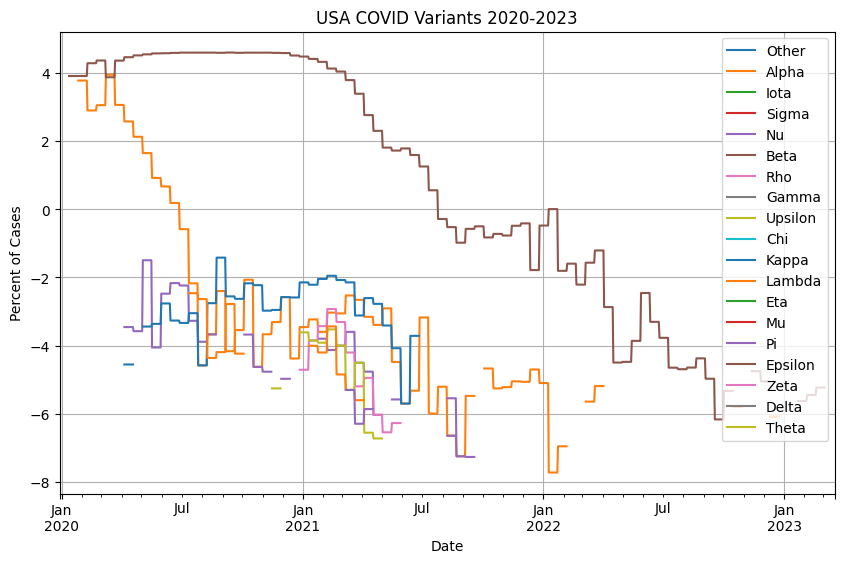

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_us = local_merged_df[local_merged_df['Country'] == 'United States']
df_us = df_us.set_index('date')

# take the log of the variant percents. The scale doesn't show the small variants
for col in df_us.select_dtypes(include=np.number).columns:
    df_us[col] = np.log(df_us[col])

# Plotting the time series
df_us.plot(title='USA COVID Variants 2020-2023', xlabel='Date', ylabel='Percent of Cases', figsize=(10, 6))
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [24]:
!pip install -q keras-tcn
from tcn import TCN
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tqdm.notebook import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


**Do Train/Test Split**

In [25]:
X = local_merged_df.drop(['HighestVariant'],axis=1)     # remove our target variable
y = local_merged_df['HighestVariant']                   # make a y axis from it
X_train, X_test_raw, y_train, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test_raw.shape}")
print(f"Shape of y_test: {y_test_raw.shape}")

Shape of X_train: (181772, 24)
Shape of y_train: (181772,)
Shape of X_test: (45443, 24)
Shape of y_test: (45443,)


**Get Inverse Class Weights for Weighting Models that Accept it**

In [26]:
# Get class counts
class_counts = y_train.value_counts()
y_len = len(y_train)

# Compute class weights (relative representation)
class_weights = class_counts / y_len

# Convert to DataFrame for better visualization
df_weights = class_weights.reset_index()
df_weights.columns = ['Class', 'Weight']

# Display result
print(df_weights)

# Get class counts
class_counts = y_train.value_counts()
total_samples = len(y_train)

# Compute weights (inverse of frequency)
weights = total_samples / (len(class_counts) * class_counts)

# Convert to dictionary format for model usage
class_weight_dict = weights.to_dict()

print("The following class weights are what we'd use to normalize the weights")
print("Class Weights:", class_weight_dict)

      Class    Weight
0   Unknown  0.607987
1      Beta  0.340614
2     Alpha  0.026099
3     Delta  0.015668
4     Kappa  0.006200
5        Pi  0.001557
6        Nu  0.001243
7    Lambda  0.000369
8   Epsilon  0.000132
9     Other  0.000066
10       Mu  0.000066
The following class weights are what we'd use to normalize the weights
Class Weights: {'Unknown': 0.14952474571530808, 'Beta': 0.26689807269320787, 'Alpha': 3.4832898972865247, 'Delta': 5.8022216547497445, 'Kappa': 14.662579656368477, 'Pi': 58.39126244779955, 'Nu': 73.11826226870474, 'Lambda': 246.63772048846675, 'Epsilon': 688.530303030303, 'Other': 1377.060606060606, 'Mu': 1377.060606060606}


**Perform Encoding and Scaling**

Here we make all strings become numeric and scale the numerical data.

In [27]:
# we'll now use the preprocessor on the training data

X_train, y_train = do_preproc(X_train, y_train, transform_only = False) # we want to fit_transform

# Time to drop our date. We need to have everything numeric and scaled
X_train.drop(columns='date', inplace=True)


Label encoding completed.
Numerical columns cleaned and renamed.
Data normalization completed.


In [28]:
# Show the post-encoded/scaled data
X_train.head(1)

,Country,UrbanPop,HospBedDensity,Obesity,Other,Alpha,Iota,Sigma,Nu,Beta,Rho,Gamma,Upsilon,Chi,Kappa,Lambda,Eta,Mu,Pi,Epsilon,Zeta,Delta,Theta,scaled_date
188231,193,1.534433,0.012024,-0.979045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.879252


In [29]:
unique_rows, counts = np.unique(y_train, axis=0, return_counts=True)
y_len = len(y_train)
# Display results
print("Unique Rows:\n", unique_rows)
print("Counts:", counts)
print(len(y_train))


Unique Rows:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Counts: [110515    283     12    226     12     67   1127     24   2848  61914
   4744]
181772


**Preprocess Data and Save File**

In [30]:
# Save Preprocessed Data

# Save the preprocessed data to a CSV file
X_train.to_csv('/content/drive/MyDrive/project1_data/preprocessed_data.csv', index=False)
print("Preprocessed data saved successfully.")

Preprocessed data saved successfully.




---
End Preprocessing

---



## Model Building
The data are ready to input into a model

**First Define Model Selection, Visualizing, and Measuring Methods**

In [31]:

# -------------------------------------------- model evaluation ----------------------
# this method will output model metrics and a confusion matrix
def eval_model(X_in, y_in):
  # Evaluate the model
  model_score = model.evaluate(X_in, y_in, verbose=0)
  predict_x = model.predict(X_in)
  y_pred = np.argmax(predict_x, axis=1)
  y_true = np.argmax(y_in, axis=1)  # Convert one-hot to class labels
  precision = precision_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  cm = confusion_matrix(y_true, y_pred)

  print(f"Model evaluation - Loss: {model_score[0]}, Accuracy: {model_score[1]}")

  print( 'precision = ' + str(precision) + '\nrecall = ' + str(recall))
  print('Confusion matrix on training data:\n- x-axis is true labels.\n- y-axis is predicted labels')
  print(pd.DataFrame(cm).head(13))
  print(" ")
  print(classification_report(y_true, y_pred))


# -----------------------------------------------------------------------------------
# a method to plot the true vs predicted for each epoch in model.fit
#   To use make sure you use      history = model.fit(......)
def plot_model_history(axis, history, autoshow=True):
  pd.DataFrame(history.history).plot(ax=axis, title='True vs. Predicted')
  # If we're going to put plots side-by-side don't show them here
  if autoshow:
    plt.show()

# ------------------------------------------------------------------
# A method to create a predicted vs actuals heatmap
def plot_predicted_vs_actual_map(axis, y_pred, y_actual, autoshow=True):
  # Scatter plot of predictions vs actuals
  axis.scatter(y_actual.argmax(axis=1), y_pred.argmax(axis=1), alpha=0.5)
  axis.set_title('Predictions vs Actuals')
  axis.set_xlabel('Actual Values')
  axis.set_ylabel('Predicted Values')
  if autoshow:  # only show if we need to
    plt.show()

def plot_trn_vs_val(axis, history, autoshow=True):
  # Plot training & validation accuracy values
  axis.plot(history.history['accuracy'], label='Train Accuracy')
  axis.plot(history.history['val_accuracy'], label='Validation Accuracy')
  axis.set_title('Model Accuracy')
  axis.set_ylabel('Accuracy')
  axis.set_xlabel('Epoch')
  if autoshow:
    plt.show

# This will call all the other plot methods so we can standardize
def plot_viz_wide(width, history, y_pred, y_actual):
  fig, axes = plt.subplots(1, width, figsize=(7,3))

  # plot training vs validation
  plot_trn_vs_val(axes[0], history, False)

  # Plot training & validation loss values
  plot_model_history(axes[1], history, False)

  # Plot the predicted vs actual
  plot_predicted_vs_actual_map(axes[2], y_pred, y_actual, False)

  plt.tight_layout()


###Feedforward Neural Network

**Import Libraries**

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Input, BatchNormalization, LeakyReLU
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
%matplotlib inline

**Configure Early Stopping**

In [33]:

early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor loss
    patience=8,         # no improvement in N epochs, stop
    restore_best_weights=True,  # restore the best weights
    mode='max'           # 'min' for loss, 'max' for accuracy
)

**Build the Model**

In [34]:
# Build the model

model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))  # x.shape[1] has count of input features.

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01))) # relu with L2 regularization
model.add(BatchNormalization())   # Stabilize training between layers
model.add(LeakyReLU(alpha=0.01))  # Allow small negative weights
model.add(Dropout(0.3))  # Dropout with 20% rate

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())   # Stabilize training between layers
model.add(LeakyReLU(alpha=0.01))  # Allow small negative weights
model.add(Dropout(0.3))  # Dropout with 20% rate

model.add(Dense(64, activation='relu'))
model.add(Dense(pd.DataFrame(y_train).shape[1], activation='softmax'))  # Adjust activation based on your target

# Print the model summary
model.summary()

# Set the learning rate on the adam optimizer
optimizer = Adam(learning_rate=0.0005)  # Lower learning rate

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=200, batch_size=128, validation_split=0.2, callbacks=[early_stopping])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,707 (116.04 KB)

 Trainable params: 29,195 (114.04 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/200
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8939 - loss: 0.6323 - val_accuracy: 0.6288 - val_loss: 7.6056
Epoch 2/200
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9452 - loss: 0.2076 - val_accuracy: 0.3803 - val_loss: 4.0815
Epoch 3/200
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9542 - loss: 0.1602 - val_accuracy: 0.9324 - val_loss: 0.4181
Epoch 4/200
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9533 - loss: 0.1520 - val_accuracy: 0.9055 - val_loss: 0.9418
Epoch 5/200
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9374 - loss: 0.1928 - val_accuracy: 0.9506 - val_loss: 0.2428
Epoch 6/200
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9523 - loss: 0.1530 - val_accuracy: 0.3786 - val_loss: 2.0798
Epoch 7/200
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9568 - loss: 0.1536 - val_accuracy: 0.9532 - val_loss: 0.2394
Epoch 8/200
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9588 - loss: 0

**Measure the Model**

In [35]:

# call it for this model but we'll reuse the method later
eval_model(X_train, y_train)
tuned_ann_score = model.evaluate(X_train, y_train, verbose=0)

5681/5681 ━━━━━━━━━━━━━━━━━━━━ 6s 993us/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Model evaluation - Loss: 7.555850028991699, Accuracy: 0.6256904006004333
precision = 0.3963866386604819
recall = 0.2512580473193135
Confusion matrix on training data:
- x-axis is true labels.
- y-axis is predicted labels
     0   1     2   3    4   5   6   7   8      9       10
0   945   0     9   0    0   0   0   0   0   2311    1479
1     0   0    12   0    0   0   0  54   0  35318   26530
2     0   0  1952   0    0   0   0   0   0      0     896
3     0   0     0   0    0   0   0   0   0      0      24
4     0   0    19   0  125   0   0   0   0    419     564
5     0   0     0   0    0   0   0   0   0     21      46
6     0   0     0   0    0   0   0   0   0      0      12
7     0   0    45   0    0   0   0  85   0     21      75
8     0   0     0   0    0   0   0   0   0      0      12
9     0   0     0   0    0   0   0   0   0    111     172
10    0   0     0   0    0   0   0   0   0      0  110515
 
              precision    recall  f1-score   support

           0       1.00   

**Visualize the Model**

5681/5681 ━━━━━━━━━━━━━━━━━━━━ 6s 968us/step


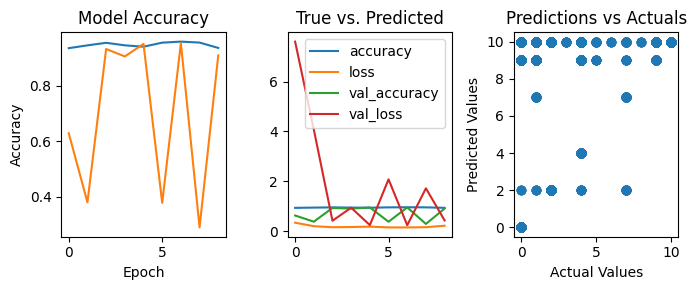

In [36]:
# Plot the resultsl
y_pred = model.predict(X_train)
plot_viz_wide(3, history, y_pred, y_train)


###RNN + LSTM MODEL

**Build the RNN + LSTM Model**

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau

# reshape X_train for LSTM
X_train_LSTM = X_train.to_numpy(dtype=np.float32)
X_train_LSTM = X_train_LSTM.reshape((X_train.shape[0], 1, X_train.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_LSTM.shape[0], 24), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(pd.DataFrame(y_train).shape[1], activation='softmax'))  # getting the number of unique classes in y

# Print the model summary
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 181772, 128)         │          78,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 181772, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 11)                  │             363 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,187 (508.54 KB)

 Trainable params: 130,187 (508.54 KB)

 Non-trainable params: 0 (0.00 B)

**Train the RNN + LSTM Model**

In [38]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model and save the history
history = model.fit(X_train_LSTM, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])


Epoch 1/10
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9281 - loss: 0.2822 - val_accuracy: 0.9679 - val_loss: 0.1233 - learning_rate: 0.0010
Epoch 2/10
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.9723 - loss: 0.1053 - val_accuracy: 0.9732 - val_loss: 0.1116 - learning_rate: 0.0010
Epoch 3/10
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9782 - loss: 0.0844 - val_accuracy: 0.9767 - val_loss: 0.0931 - learning_rate: 0.0010
Epoch 4/10
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.9799 - loss: 0.0769 - val_accuracy: 0.9806 - val_loss: 0.0683 - learning_rate: 0.0010
Epoch 5/10
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.9819 - loss: 0.0707 - val_accuracy: 0.9836 - val_loss: 0.0589 - learning_rate: 0.0010
Epoch 6/10
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9813 - loss: 0.0718 - val_accuracy: 0.9857 - val_loss: 0.0519 - learning_rate: 0.0010
Epoch 7/10
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9

**Evaluate the RNN + LSTM Model**

In [39]:
# call it for this model but we'll reuse the method later
eval_model(X_train_LSTM, y_train)
lstm_score = model.evaluate(X_train_LSTM, y_train, verbose=0)

5681/5681 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Model evaluation - Loss: 0.042496927082538605, Accuracy: 0.9891787767410278
precision = 0.9980594359292172
recall = 0.9514772601518197
Confusion matrix on training data:
- x-axis is true labels.
- y-axis is predicted labels
      0      1     2   3     4   5   6    7   8    9       10
0   4570     82     0   0     0   0   0    0   0    0      92
1     11  60328     0   0     0   0   0    0   0    0    1575
2      0      0  2838   0     0   0   0    0   0    0      10
3      0      0     0  24     0   0   0    0   0    0       0
4      0     18     0   0  1030   0   0    0   0    0      79
5      0      0     0   0     0  67   0    0   0    0       0
6      0      0     0   0     0   0  12    0   0    0       0
7      0     32     0   0     0   0   0  194   0    0       0
8      0      0     0   0     0   0   0    0  12    0       0
9      0     68     0   0     0   0   0    0   0  215       0
10     0      0     0   0     0   0   0    0   0   

**Visualize the Model Metrics per Epoch**

5681/5681 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


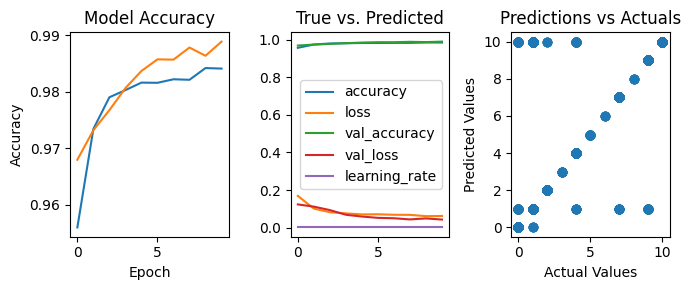

In [40]:
# Plot the resultsl
y_pred = model.predict(X_train_LSTM)
plot_viz_wide(3, history, y_pred, y_train)


**Use Unseen Test Data to Evaluate the RNN + LSTM Model**

Prepare the Test Data

The test data have not been scaled, normalized, filtered, etc.  Apply the preprocessing transforms we fit and saved earlier.

In [41]:
# encode and scale the test data
X_test, y_test = do_preproc(X_test_raw, y_test_raw, transform_only = True)  # we don't want to re-fit the data
X_test.drop(columns=['date'], inplace=True)
# reshape X_train for LSTM. We did this same thing for X_train_LSTM so this has to match
X_test_LSTM = X_test.copy()
X_test_LSTM = X_test_LSTM.values.reshape((X_test_LSTM.shape[0], 1, X_test_LSTM.shape[1]))


Label encoding completed.
Numerical columns cleaned and renamed.
Data normalization completed.


**Measure the Model on Unseen Data**

In [42]:
# Evaluate the model
LSTM_score = model.evaluate(X_test_LSTM, y_test, verbose=0)
print(f"Model evaluation - Loss: {LSTM_score[0]}, Accuracy: {LSTM_score[1]}")

Model evaluation - Loss: 0.04604148864746094, Accuracy: 0.9881830215454102


**Visualize Predictions vs. Actuals**

1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


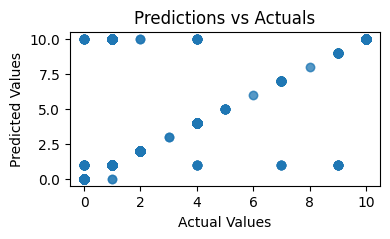

In [43]:
# Scatter plot of predictions vs actuals
y_pred = model.predict(X_test_LSTM)
plt.figure(figsize=(4,2))
plt.scatter(y_test.argmax(axis=1), y_pred.argmax(axis=1), alpha=0.5)
plt.title('Predictions vs Actuals')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


###GRNN MODEL

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Build the GRNN model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))  # Input layer
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Print the model summary
model.summary()

# Set the learning rate on the Adam optimizer
optimizer = Adam(learning_rate=0.0005)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model and save the history
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
grnn_score = model.evaluate(X_test, y_test, verbose=0)
print(f"Model evaluation - Loss: {grnn_score[0]}, Accuracy: {grnn_score[1]}")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 128)                 │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,683 (112.04 KB)

 Trainable params: 28,683 (112.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8207 - loss: 1.3280 - val_accuracy: 0.9358 - val_loss: 0.2519 - learning_rate: 5.0000e-04
Epoch 2/5
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9453 - loss: 0.2323 - val_accuracy: 0.9647 - val_loss: 0.1517 - learning_rate: 5.0000e-04
Epoch 3/5
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9584 - loss: 0.1804 - val_accuracy: 0.9625 - val_loss: 0.1647 - learning_rate: 5.0000e-04
Epoch 4/5
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9618 - loss: 0.1701 - val_accuracy: 0.9697 - val_loss: 0.1386 - learning_rate: 5.0000e-04
Epoch 5/5
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9600 - loss: 0.1769 - val_accuracy: 0.9632 - val_loss: 0.1623 - learning_rate: 5.0000e-04
Model evaluation - Loss: 0.1348871886730194, Accuracy: 0.9712386727333069


In [45]:
# output model metrics
eval_model(X_train, y_train)

5681/5681 ━━━━━━━━━━━━━━━━━━━━ 5s 852us/step
Model evaluation - Loss: 0.1346571445465088, Accuracy: 0.9708371162414551
precision = 0.613266574907686
recall = 0.48901301604997616
Confusion matrix on training data:
- x-axis is true labels.
- y-axis is predicted labels
      0      1     2   3    4   5   6    7   8    9       10
0   4357    181     0   0    0   0   0    0   0    0     206
1     11  57854     0   0    0   0   0    0   0    0    4049
2      0      0  2812   0    0   0   0    0   0    0      36
3      0     24     0   0    0   0   0    0   0    0       0
4      0    240     0   0  701   0   0   11   0    0     175
5      0     55     0   0    0   0   0    0   0   12       0
6     12      0     0   0    0   0   0    0   0    0       0
7      0    106     0   0    0   0   0  109   0    0      11
8      0      0     0   0   12   0   0    0   0    0       0
9      0     93     0   0    0   0   0    0   0  123      67
10     0      0     0   0    0   0   0    0   0    0  110515
 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

**Visualize Model**

5681/5681 ━━━━━━━━━━━━━━━━━━━━ 5s 797us/step


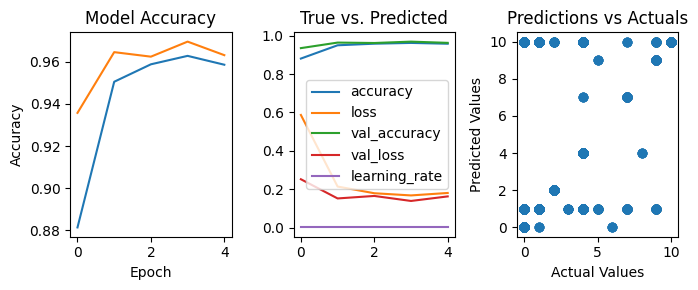

In [46]:
# Plot the resultsl
y_pred = model.predict(X_train)
plot_viz_wide(3, history, y_pred, y_train)


###ANN MODEL

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming your preprocessed data is stored in X_train, y_train, X_test, y_test

# Build the ANN model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer with 64 neurons
model.add(Dense(32, activation='relu'))  # Hidden layer with 32 neurons
model.add(Dense(16, activation='relu'))  # Another hidden layer with 16 neurons
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer with 1 neuron for binary classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4545/4545 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9157 - loss: 0.4812 - val_accuracy: 0.9690 - val_loss: 0.1046
Epoch 2/5
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9697 - loss: 0.1148 - val_accuracy: 0.9735 - val_loss: 0.1146
Epoch 3/5
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9820 - loss: 0.0734 - val_accuracy: 0.9849 - val_loss: 0.0475
Epoch 4/5
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9850 - loss: 0.0618 - val_accuracy: 0.9876 - val_loss: 0.0417
Epoch 5/5
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9887 - loss: 0.0461 - val_accuracy: 0.9901 - val_loss: 0.0356


In [48]:
# Evaluate the model
ANN_loss, ANN_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {ANN_accuracy}')

# output model metrics
eval_model(X_train, y_train)

1421/1421 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9894 - loss: 0.0384  
Test Accuracy: 0.9893712997436523
5681/5681 ━━━━━━━━━━━━━━━━━━━━ 5s 839us/step
Model evaluation - Loss: 0.03428791090846062, Accuracy: 0.9903230667114258
precision = 0.9983035549407536
recall = 0.9423065524941087
Confusion matrix on training data:
- x-axis is true labels.
- y-axis is predicted labels
      0      1     2   3    4   5   6    7   8    9       10
0   4478    185     0   0    0   0   0    0   0    0      81
1      0  60664     0   0    0   0   0    0   0    0    1250
2      0      0  2848   0    0   0   0    0   0    0       0
3      0      0     0  24    0   0   0    0   0    0       0
4      0     99     0   0  995   0   0    0   0    0      33
5      0      0     0   0    0  67   0    0   0    0       0
6      0      0     0   0    0   0  12    0   0    0       0
7      0     55     0   0    0   0   0  171   0    0       0
8      0      0     0   0    0   0   0    0  12    0       0
9      0 

5681/5681 ━━━━━━━━━━━━━━━━━━━━ 4s 743us/step


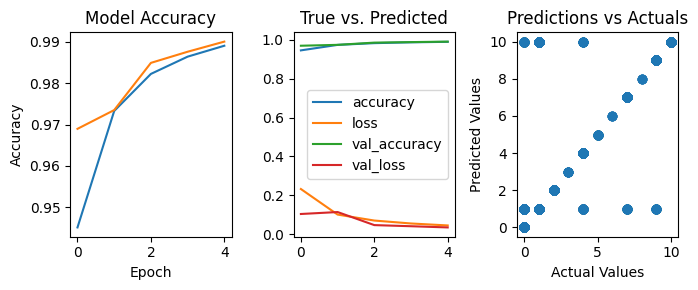

In [49]:
# Plot the resultsl
y_pred = model.predict(X_train)
plot_viz_wide(3, history, y_pred, y_train)


###Multilayer Perceptron

In [50]:
# MLP
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(8, 2), random_state=1)
history = clf.fit(X_train, y_train)
# Evaluate the model
# OVR doesn't expose model.evaluate so have to use just accuracy on predictions
y_pred = (clf.predict(X_test) > 0.5).astype(int)
# output model metrics
eval_model(X_train, y_train)

5681/5681 ━━━━━━━━━━━━━━━━━━━━ 4s 761us/step
Model evaluation - Loss: 0.03428791090846062, Accuracy: 0.9903230667114258
precision = 0.9983035549407536
recall = 0.9423065524941087
Confusion matrix on training data:
- x-axis is true labels.
- y-axis is predicted labels
      0      1     2   3    4   5   6    7   8    9       10
0   4478    185     0   0    0   0   0    0   0    0      81
1      0  60664     0   0    0   0   0    0   0    0    1250
2      0      0  2848   0    0   0   0    0   0    0       0
3      0      0     0  24    0   0   0    0   0    0       0
4      0     99     0   0  995   0   0    0   0    0      33
5      0      0     0   0    0  67   0    0   0    0       0
6      0      0     0   0    0   0  12    0   0    0       0
7      0     55     0   0    0   0   0  171   0    0       0
8      0      0     0   0    0   0   0    0  12    0       0
9      0     56     0   0    0   0   0    0   0  227       0
10     0      0     0   0    0   0   0    0   0    0  110515


**Since we know there's a large class imbalance, try upsampling**

In [51]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score
# Apply upsampling
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = oversampler.fit_resample(X_test, y_test)

# Train a model
clf = MLPClassifier(solver='lbfgs', alpha=1e-4,
                    hidden_layer_sizes=(8, 2), random_state=1)
history = clf.fit(X_train_resampled, y_train_resampled)

eval_model(X_test_resampled, y_test_resampled)


9473/9473 ━━━━━━━━━━━━━━━━━━━━ 7s 757us/step
Model evaluation - Loss: 0.25492244958877563, Accuracy: 0.9427170753479004
precision = 0.9609744515248102
recall = 0.9427170789800975
Confusion matrix on training data:
- x-axis is true labels.
- y-axis is predicted labels
       0      1      2      3      4      5      6      7      8      9   \
0   26032   1153      0      0      0      0      0      0      0      0   
1       0  26915      0      0      0      0      0      0      0      0   
2       0      0  27557      0      0      0      0      0      0      0   
3       0      0      0  27557      0      0      0      0      0      0   
4       0   2532      0      0  24146      0      0      0      0      0   
5       0      0      0      0      0  27557      0      0      0      0   
6       0      0      0      0      0      0  27557      0      0      0   
7       0   6038      0      0      0      0      0  21519      0      0   
8       0      0      0      0      0      0    

Upsampling wasn't markedly better as some of our models performed quite well, but it did make a nice clean confusion matrix.

###Logistic Regression

We produce a basic Logistic Regression model for comparison to our neural networks

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Create a logistic regression model based on an OVR classifier
model = OneVsRestClassifier(LogisticRegression())

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
# OVR doesn't expose model.evaluate so have to use just accuracy on predictions
y_pred = model.predict(X_test)
LR_accuracy = accuracy_score(y_test, y_pred)



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Assuming your preprocessed data is stored in X_train, y_train, X_test, y_test
features_count = len(X_train.columns)

# Build the ANN model
model = Sequential()
model.add(Conv1D(filters=512, kernel_size=5, padding='same', activation='relu', input_shape=(1,features_count)))
model.add(Flatten())
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer with 64 neurons
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))  # Hidden layer with 32 neurons
model.add(Dense(16, activation='relu'))  # Another hidden layer with 16 neurons
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer with 1 neuron for binary classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model and save the history
X_train_shaped = X_train.to_numpy().reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_shaped = X_test.to_numpy().reshape(X_test.shape[0], 1, X_test.shape[1])
# Train the model

model.compile(optimizer="adam", loss='mse')
history = model.fit(X_train_shaped, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])
# OVR doesn't expose model.evaluate so have to use just accuracy on predictions
y_pred = model.predict(X_test_shaped) #(model.predict(X_test_shaped) > 0.5).astype(int)
# output model metrics
# Assuming y_pred contains probabilities or continuous scores:
y_pred_binary = (y_pred > 0.5).astype(int)
print(accuracy_score(y_test, y_pred_binary))


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4545/4545 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9150 - loss: 0.0134 - val_accuracy: 0.9671 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 2/5
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9603 - loss: 0.0069 - val_accuracy: 0.9770 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 3/5
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9607 - loss: 0.0069 - val_accuracy: 0.9580 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 4/5
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9601 - loss: 0.0071 - val_accuracy: 0.9664 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 5/5
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9656 - loss: 0.0061 - val_accuracy: 0.9710 - val_loss: 0.0052 - learning_rate: 0.0010
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
0.9760139075325133


**Plot the LR Results for Comparison**

5681/5681 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


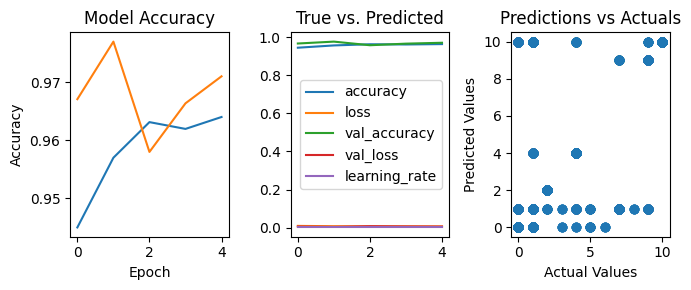

In [54]:
# Plot the resultsl
y_pred = model.predict(X_train_shaped)
plot_viz_wide(3, history, y_pred, y_train)


The logistic regression did very well but not as well as our neural networks. It's likely this is due to the neural networks' ability to more accurately model non-linear and higher-order relationships.

###Keras-TCN

We attempted to implement Keras-TCN

In [55]:
'''
!pip install -q keras-tcn --no-dependencies
from tcn import TCN, tcn_full_summary
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences

n_epochs = 10
n_splits =  5
n_features = X_train.shape[-1]

kf = KFold(n_splits=n_splits, shuffle=False)
test_preds = []

model = Sequential([
    # Here is the Temporal Convolutional Network (TCN):
    TCN(input_shape=(1,features_count), nb_filters=128, return_sequences=True, dilations=[1, 2, 4, 8, 16, 32]),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='selu'),
    Dense(1),
])

model.compile(
    optimizer="adam",
    loss="mae",
    metrics=["accuracy"]
)
num_samples = X_train.shape[0]
train_data = X_train.to_numpy()[:num_samples].reshape(-1, 1, 13)
test_data = X_test.to_numpy()[:X_test.shape[0]].reshape(-1, 1, 13)

print(model.input_shape)
history = model.fit(
    X_train_shaped, y_train,
    validation_data=(X_test_shaped, y_test),
    epochs=n_epochs,
    batch_size=1024,
    callbacks=[early_stopping, reduce_lr]
)
'''

'\n!pip install -q keras-tcn --no-dependencies\nfrom tcn import TCN, tcn_full_summary\nfrom sklearn.model_selection import KFold\nfrom tensorflow.keras.preprocessing.sequence import pad_sequences\n\nn_epochs = 10\nn_splits =  5\nn_features = X_train.shape[-1]\n\nkf = KFold(n_splits=n_splits, shuffle=False)\ntest_preds = []\n\nmodel = Sequential([\n    # Here is the Temporal Convolutional Network (TCN):\n    TCN(input_shape=(1,features_count), nb_filters=128, return_sequences=True, dilations=[1, 2, 4, 8, 16, 32]),\n    Flatten(),\n    Dense(64, activation=\'relu\'),\n    Dropout(0.2),\n    Dense(50, activation=\'selu\'),\n    Dense(1),\n])\n\nmodel.compile(\n    optimizer="adam",\n    loss="mae",\n    metrics=["accuracy"]\n)\nnum_samples = X_train.shape[0]\ntrain_data = X_train.to_numpy()[:num_samples].reshape(-1, 1, 13)\ntest_data = X_test.to_numpy()[:X_test.shape[0]].reshape(-1, 1, 13)\n\nprint(model.input_shape)\nhistory = model.fit(\n    X_train_shaped, y_train,\n    validation_data

In [56]:
#y_pred = model.predict(test_data) #(model.predict(X_test_shaped) > 0.5).astype(int)
#y_pred_binary = (abs(y_pred) > 0.5).astype(int)
#print(accuracy_score(y_test, y_pred_binary))

**Summary**

In [57]:
print(f"Tuned ANN loss: {tuned_ann_score[0]}, accuracy: {tuned_ann_score[1]}")
print(f"LSTM loss: {LSTM_score[0]}, accuracy: {LSTM_score[1]}")
print(f"GRNN loss: {grnn_score[0]}, accuracy: {grnn_score[1]}")
print(f"ANN loss: {ANN_loss}, accuracy: {ANN_accuracy}")
print(f"LR accuracy: {LR_accuracy}")

Tuned ANN loss: 7.555850028991699, accuracy: 0.6256904006004333
LSTM loss: 0.04604148864746094, accuracy: 0.9881830215454102
GRNN loss: 0.1348871886730194, accuracy: 0.9712386727333069
ANN loss: 0.03789432719349861, accuracy: 0.9893712997436523
LR accuracy: 0.9684439847721321


**Follow-up and Refinement Opportunities**

We did extensive pre-processing and analysis, most of which was not included in this notebook.  Our focus here was to get data of reasonable quality to explore methods of building and measuring deep learning models and techniques.  We would continue to refine these models by:


1.   Performing thorough feature selection and dimensionality reduction
2.   Perform deeper analysis to identify and reduce outlier impact on models
3.   Explore ensemble and cross validation methods specific to neural networks



##Literature Review

Works reviewed:



Bird, J. J., Barnes, C. M., Premebida, C., Ekárt, A., & Faria, D. R. (2020). Country-level pandemic risk and preparedness classification based on COVID-19 data: A machine learning approach. PLoS ONE, 15(10), e0241332.

Chin, V., Ioannou, B., Marchant, R., Samia, N. I., & Colijn, C. (2020). CoronaTracker: worldwide COVID-19 outbreak data analysis and prediction. Bulletin of the World Health Organization, 1-32.

Chin, V., Samia, N. I., Marchant, R., Rosen, O., Ioannou, B., Britton, T., ... & Colijn, C. (2020). A case study in model failure? COVID-19 daily deaths and ICU bed utilisation predictions in New York State. medRxiv.

Franceschini, L. (2024, April). The World Factbook by CIA (Version 4). Kaggle. Retrieved January 29, 2025, from https://www.kaggle.com/datasets/lucafrance/the-world-factbook-by-cia

Gal, Y., & Ghahramani, Z. (2016). Dropout as a Bayesian approximation: Representing model uncertainty in deep learning. International Conference on Machine Learning (ICML). Retrieved from https://arxiv.org/abs/1506.02142

Giordano, D. (2022). SARS-CoV-2-Variants [GitHub repository]. GitHub. Retrieved from https://github.com/3dgiordano/SARS-CoV-2-Variants

Karthikeyan, A., Garg, A., Vinod, P. K., & Priyakumar, U. D. (2022). Generalizable prediction of COVID-19 mortality on worldwide patient data. JAMIA Open, 5(2), ooac036.

Kipf, T. N., & Welling, M. (2017). Semi-supervised classification with graph convolutional networks. International Conference on Learning Representations (ICLR). Retrieved from https://arxiv.org/abs/1609.02907

Mollalo, A., Rivera, K. M., & Vahedi, B. (2020). Artificial Neural Network Modeling of Novel Coronavirus (COVID-19) Incidence Rates across the Continental United States. International Journal of Environmental Research and Public Health, 17(12), 4204.

Neal, R. M. (2012). Bayesian learning for neural networks. Springer Science & Business Media.

Sarmiento Varón L, González-Puelma J, Medina-Ortiz D, Aldridge J, Alvarez-Saravia D, Uribe-Paredes R, Navarrete MA. The role of machine learning in health policies during the COVID-19 pandemic and in long COVID management. Front Public Health. 2023 Apr 11;11:1140353. doi: 10.3389/fpubh.2023.1140353. PMID: 37113165; PMCID: PMC10126380.

Tiwari, S., Kumar, S., & Guleria, K. (2020). A mathematical modelling approach in the spread of the novel 2019 coronavirus SARS-CoV-2 (COVID-19) pandemic. Electronic Journal of General Medicine, 17(4), em205.

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł., & Polosukhin, I. (2017). Attention is all you need. Advances in Neural Information Processing Systems, 30. Retrieved from https://papers.nips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf

Wu, C., Xiao, L., Chen, B., & others. (2020). COVID-BERT: A pre-trained language model for COVID-19. arXiv preprint arXiv:2004.03188. Retrieved from https://arxiv.org/abs/2004.03188

Yang, Z., Zeng, Z., Wang, K., Wong, S. S., Liang, W., Zanin, M., ... & He, J. (2020). Global prediction system for COVID-19 pandemic. Science Bulletin, 65(22), 1884-1887.

Yang, Z., Zeng, Z., Wang, K., Wong, S. S., Liang, W., Zanin, M., ... & He, J. (2020). Modified SEIR and AI prediction of the epidemics trend of COVID-19 in China under public health interventions. Journal of Thoracic Disease, 12(3), 165.

Zhou, J., Cui, G., Zhang, Z., Yang, C., Liu, Z., Wang, L., ... & Sun, M. (2020). Graph neural networks: A review of methods and applications. arXiv preprint arXiv:1812.08434. Retrieved from https://arxiv.org/abs/1812.08434